In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
dir_path = './data/CMaps/'

index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# Load data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

print(f"Train data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Test labels shape: {y_test.shape}")

Train data shape: (20631, 26)
Test data shape: (13096, 26)
Test labels shape: (100, 1)


In [3]:
# Add RUL to training data
def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)

# Prepare features
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names + setting_names + drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125)

X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (20631, 14)
X_test shape: (100, 14)


## Preprocessing - Apply Same Transformations as Training

In [4]:
# Apply same preprocessing as during training
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply polynomial features
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.transform(X_test_scaled)

print(f"X_train_transformed shape: {X_train_transformed.shape}")
print(f"X_test_transformed shape: {X_test_transformed.shape}")

X_train_transformed shape: (20631, 120)
X_test_transformed shape: (100, 120)


In [5]:
# Recreate feature selection (using SVR as reference)
from sklearn.svm import SVR as SVR_temp
svr_temp = SVR_temp(kernel='linear')
svr_temp.fit(X_train_transformed, y_train_clipped)
select_features = SelectFromModel(svr_temp, threshold='mean', prefit=True)

# Get selected features
X_train_selected = X_train_transformed[:, select_features.get_support()]
X_test_selected = X_test_transformed[:, select_features.get_support()]

print(f"Selected features shape: {X_train_selected.shape}")
print(f"Number of features selected: {select_features.get_support().sum()} out of {X_train_transformed.shape[1]}")

Selected features shape: (20631, 37)
Number of features selected: 37 out of 120


## Load All Trained Models

In [7]:
# Load all saved models
models = {}

try:
    models['SVR'] = joblib.load('model/svr_model.pkl')
    print("✓ SVR model loaded")
except Exception as e:
    print(f"✗ SVR model: {e}")

try:
    models['Random Forest'] = joblib.load('model/rf_model.pkl')
    print("✓ Random Forest model loaded")
except Exception as e:
    print(f"✗ Random Forest model: {e}")

try:
    models['Gradient Boosting'] = joblib.load('model/gb_model.pkl')
    print("✓ Gradient Boosting model loaded")
except Exception as e:
    print(f"✗ Gradient Boosting model: {e}")

try:
    models['XGBoost'] = joblib.load('model/xgb_model.pkl')
    print("✓ XGBoost model loaded")
except Exception as e:
    print(f"✗ XGBoost model: {e}")

try:
    models['LightGBM'] = joblib.load('model/lgb_model.pkl')
    print("✓ LightGBM model loaded")
except Exception as e:
    print(f"✗ LightGBM model: {e}")

try:
    models['Neural Network'] = joblib.load('model/mlp_model.pkl')
    print("✓ Neural Network model loaded")
except Exception as e:
    print(f"✗ Neural Network model: {e}")

print(f"\nTotal models loaded: {len(models)}")

✓ SVR model loaded
✓ Random Forest model loaded
✓ Gradient Boosting model loaded
✓ XGBoost model loaded
✓ LightGBM model loaded
✓ Neural Network model loaded

Total models loaded: 6


## Comprehensive Model Evaluation

In [11]:
# Evaluate all models on multiple metrics
results = []
predictions = {}

for name, model in models.items():
    # Make predictions
    y_pred_train = model.predict(X_train_selected)
    y_pred_test = model.predict(X_test_selected)
    predictions[name] = y_pred_test
    
    # Calculate metrics for test set
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    
    # Calculate metrics for training set
    mse_train = mean_squared_error(y_train_clipped, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train_clipped, y_pred_train)
    
    # Calculate overfitting indicator
    overfit_score = rmse_train / rmse if rmse > 0 else 0
    
    results.append({
        'Model': name,
        'RMSE (Test)': rmse,
        'RMSE (Train)': rmse_train,
        'MAE': mae,
        'R² (Test)': r2,
        'R² (Train)': r2_train,
        'Overfit Ratio': overfit_score
    })

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('RMSE (Test)')
print("=" * 100)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)
print("\n💡 Lower RMSE and MAE are better | Higher R² is better | Overfit Ratio closer to 1.0 is better")

MODEL PERFORMANCE COMPARISON
            Model  RMSE (Test)  RMSE (Train)       MAE  R² (Test)  R² (Train)  Overfit Ratio
   Neural Network    17.648714     17.717489 12.631548   0.819629    0.819240       1.003897
Gradient Boosting    18.300695     14.302780 12.989627   0.806056    0.882202       0.781543
    Random Forest    18.388203      8.978757 13.345276   0.804197    0.953577       0.488289
         LightGBM    18.439267     14.355819 13.330694   0.803108    0.881327       0.778546
          XGBoost    18.726048     12.208936 13.239941   0.796936    0.914167       0.651976
              SVR    20.556138     19.746789 15.842242   0.755306    0.775462       0.960627

💡 Lower RMSE and MAE are better | Higher R² is better | Overfit Ratio closer to 1.0 is better


## Visual Comparison

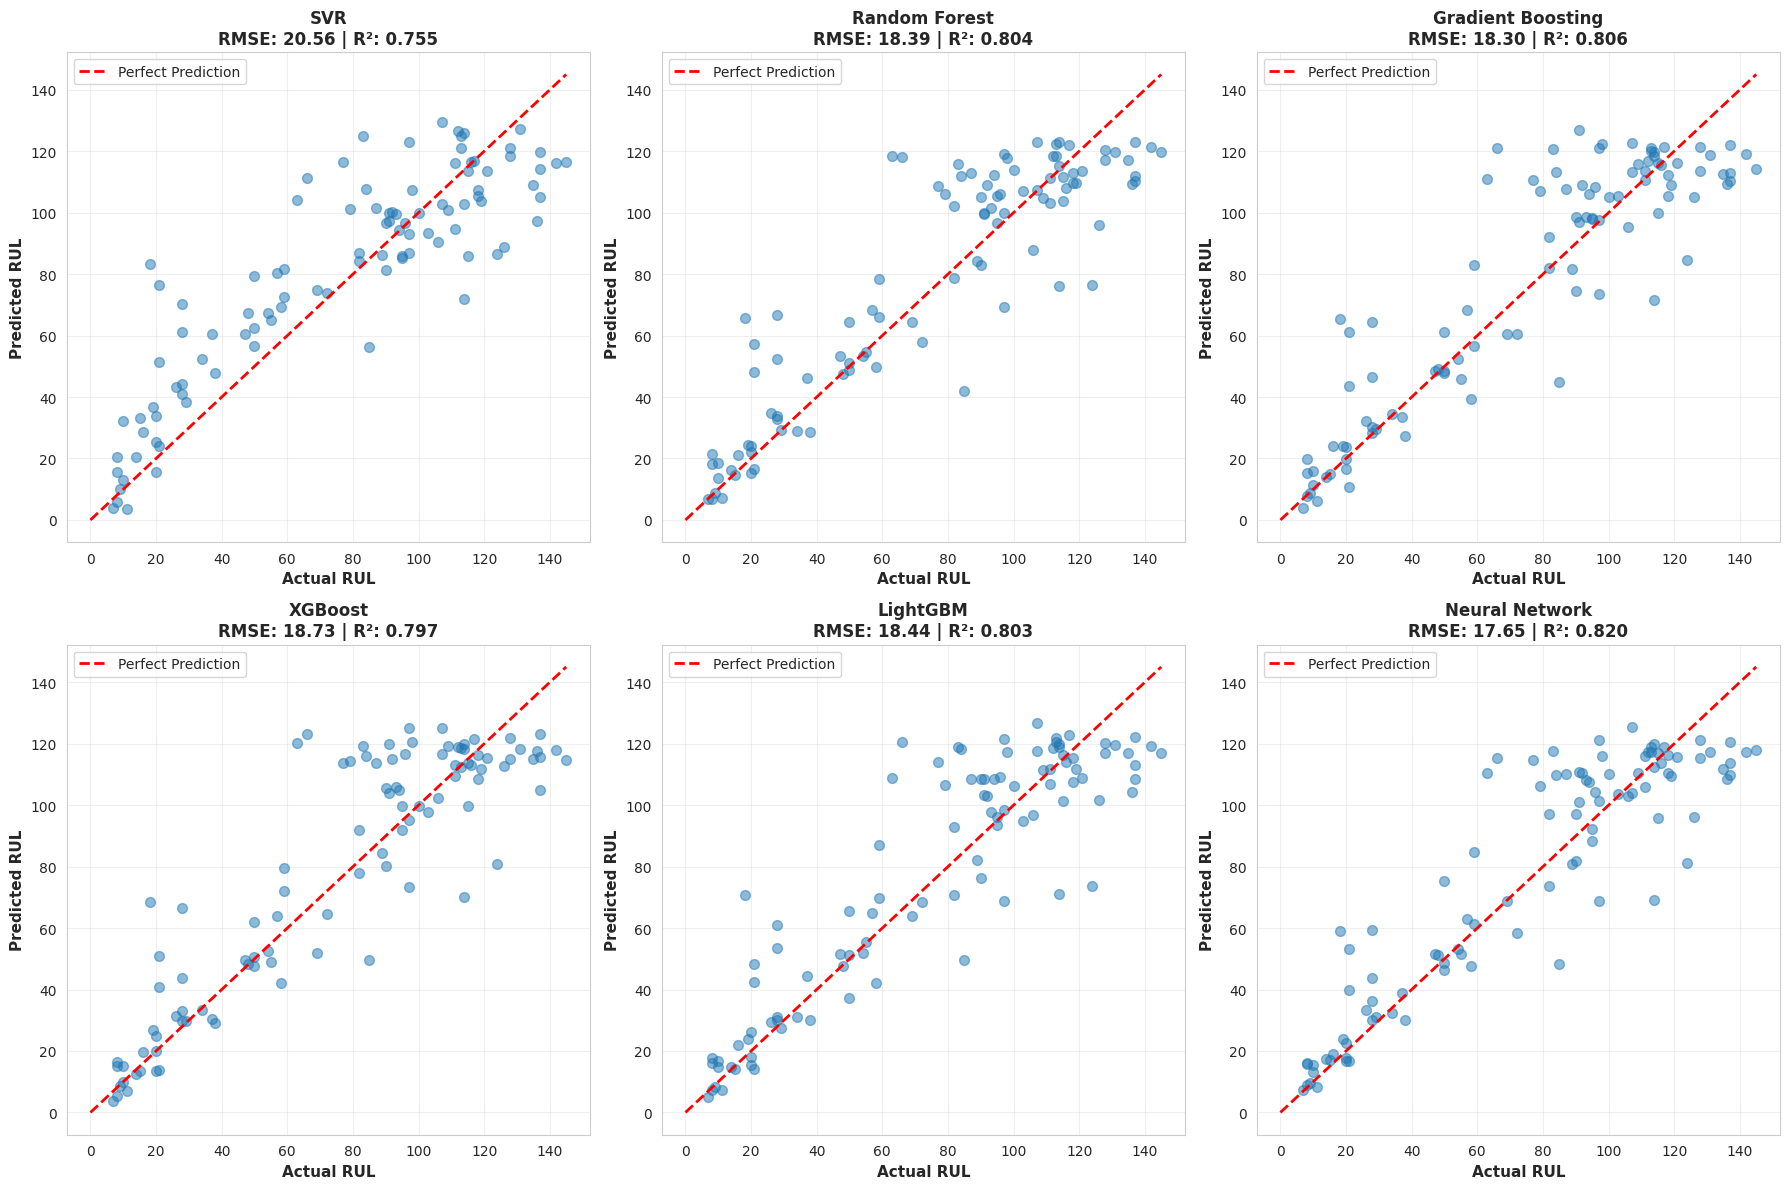

In [14]:
# Compare predictions vs actual values
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_test, y_pred, alpha=0.5, s=50)
    
    # Perfect prediction line
    max_val = max(y_test.values.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    ax.set_xlabel('Actual RUL', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted RUL', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nRMSE: {rmse:.2f} | R²: {r2:.3f}', 
                fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Error Distribution Analysis

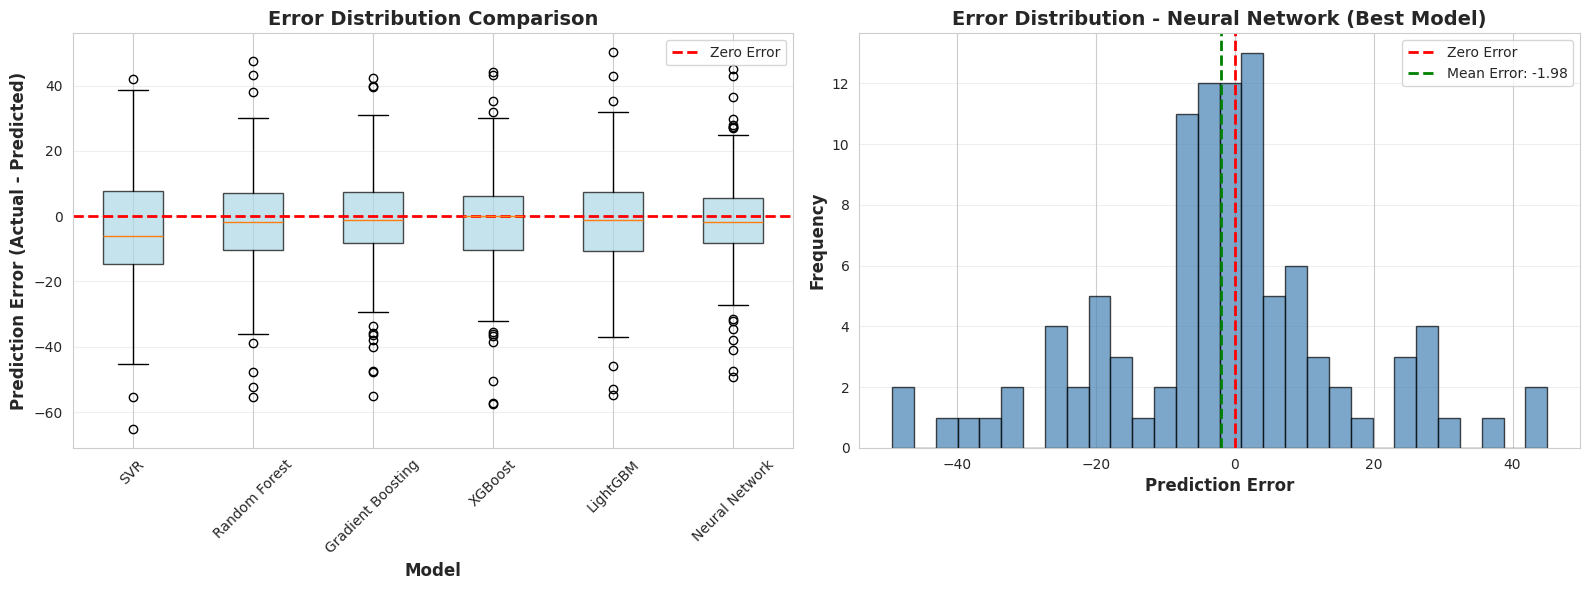


Error Statistics for Neural Network:
Mean Error: -1.98
Std Error: 17.54
Median Error: -1.94
Error Range: [-49.38, 45.00]


In [15]:
# Analyze prediction errors
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Error Distribution (Box Plot)
ax1 = axes[0]
errors_data = []
model_names = []

for name, y_pred in predictions.items():
    errors = y_test.values.flatten() - y_pred.flatten()
    errors_data.append(errors)
    model_names.append(name)

bp = ax1.boxplot(errors_data, labels=model_names, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Prediction Error (Actual - Predicted)', fontsize=12, fontweight='bold')
ax1.set_title('Error Distribution Comparison', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Error Histogram for Best Model
ax2 = axes[1]
best_model_name = results_df.iloc[0]['Model']
best_errors = y_test.values.flatten() - predictions[best_model_name].flatten()

ax2.hist(best_errors, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.axvline(x=np.mean(best_errors), color='green', linestyle='--', linewidth=2, 
           label=f'Mean Error: {np.mean(best_errors):.2f}')
ax2.set_xlabel('Prediction Error', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title(f'Error Distribution - {best_model_name} (Best Model)', 
             fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError Statistics for {best_model_name}:")
print(f"Mean Error: {np.mean(best_errors):.2f}")
print(f"Std Error: {np.std(best_errors):.2f}")
print(f"Median Error: {np.median(best_errors):.2f}")
print(f"Error Range: [{np.min(best_errors):.2f}, {np.max(best_errors):.2f}]")

## Final Recommendation

In [16]:
# Comprehensive ranking system
print("=" * 100)
print("FINAL MODEL RECOMMENDATION")
print("=" * 100)

# Create ranking based on multiple criteria
ranking_df = results_df.copy()
ranking_df['RMSE Rank'] = ranking_df['RMSE (Test)'].rank()
ranking_df['R² Rank'] = ranking_df['R² (Test)'].rank(ascending=False)
ranking_df['MAE Rank'] = ranking_df['MAE'].rank()
ranking_df['Overfit Rank'] = abs(ranking_df['Overfit Ratio'] - 1.0).rank()

# Calculate overall score (lower is better)
ranking_df['Overall Score'] = (
    ranking_df['RMSE Rank'] * 0.4 +  # RMSE is most important
    ranking_df['R² Rank'] * 0.3 +     # R² is second most important
    ranking_df['MAE Rank'] * 0.2 +    # MAE is important
    ranking_df['Overfit Rank'] * 0.1  # Overfitting check
)

ranking_df = ranking_df.sort_values('Overall Score')

print("\nFinal Rankings (based on weighted scoring):")
print("-" * 100)
for idx, row in ranking_df.iterrows():
    rank = int(row['Overall Score'] * 10)  # Scale for better readability
    print(f"Rank {ranking_df.index.get_loc(idx) + 1}: {row['Model']:<20} | "
          f"RMSE: {row['RMSE (Test)']:6.2f} | "
          f"R²: {row['R² (Test)']:6.3f} | "
          f"MAE: {row['MAE']:6.2f} | "
          f"Overfit: {row['Overfit Ratio']:5.3f}")

print("-" * 100)

# Best model recommendation
best = ranking_df.iloc[0]
print(f"\n🏆 RECOMMENDED MODEL: {best['Model']}")
print(f"   └─ Test RMSE: {best['RMSE (Test)']:.3f}")
print(f"   └─ Test R²: {best['R² (Test)']:.3f}")
print(f"   └─ MAE: {best['MAE']:.3f}")
print(f"   └─ Overfit Ratio: {best['Overfit Ratio']:.3f}")

# Model file path
print(f"\n📁 Model Location: model/{best['Model'].lower().replace(' ', '_')}_model.pkl")

# Provide context-based recommendation
print("\n💡 SELECTION CRITERIA:")
print("   • RMSE (40% weight): Primary metric for accuracy")
print("   • R² Score (30% weight): Explains variance in predictions")
print("   • MAE (20% weight): Average prediction error")
print("   • Overfitting (10% weight): Generalization capability")

print("\n📊 USE CASE RECOMMENDATIONS:")
for idx, row in ranking_df.iterrows():
    if idx == ranking_df.index[0]:
        print(f"   ✓ {row['Model']}: Best overall performance - RECOMMENDED for production")
    elif row['Overfit Ratio'] > 0.9 and row['Overfit Ratio'] < 1.1:
        print(f"   • {row['Model']}: Best generalization - Good for unseen data")
    elif row['R² (Test)'] == ranking_df['R² (Test)'].max():
        print(f"   • {row['Model']}: Best R² score - Explains most variance")

print("=" * 100)

FINAL MODEL RECOMMENDATION

Final Rankings (based on weighted scoring):
----------------------------------------------------------------------------------------------------
Rank 1: Neural Network       | RMSE:  17.65 | R²:  0.820 | MAE:  12.63 | Overfit: 1.004
Rank 2: Gradient Boosting    | RMSE:  18.30 | R²:  0.806 | MAE:  12.99 | Overfit: 0.782
Rank 3: Random Forest        | RMSE:  18.39 | R²:  0.804 | MAE:  13.35 | Overfit: 0.488
Rank 4: LightGBM             | RMSE:  18.44 | R²:  0.803 | MAE:  13.33 | Overfit: 0.779
Rank 5: XGBoost              | RMSE:  18.73 | R²:  0.797 | MAE:  13.24 | Overfit: 0.652
Rank 6: SVR                  | RMSE:  20.56 | R²:  0.755 | MAE:  15.84 | Overfit: 0.961
----------------------------------------------------------------------------------------------------

🏆 RECOMMENDED MODEL: Neural Network
   └─ Test RMSE: 17.649
   └─ Test R²: 0.820
   └─ MAE: 12.632
   └─ Overfit Ratio: 1.004

📁 Model Location: model/neural_network_model.pkl

💡 SELECTION CRITERIA